# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
from common_utils import MLP, CustomDataset, loss_fn, split_dataset, preprocess_dataset

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], test_size=0.3, random_state=0)

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """

    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for batch_size in parameters:
        X_train_folds = []
        X_val_folds = []
        y_train_folds = []
        y_val_folds = []
#         print(batch_size)
        
        for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
#             print(f"Fold {i}:")
#             print(f"  Train: index={train_index}")
#             print(f"  Test:  index={val_index}")
            
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
#             print(len(X_train_fold))
            # Preprocess the data
            scaler = preprocessing.StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            X_train_folds.append(X_train_fold_scaled)
            X_val_folds.append(X_val_fold_scaled)
            y_train_folds.append(y_train_fold)
            y_val_folds.append(y_val_fold)

        X_train_scaled_dict[batch_size] = X_train_folds
        X_val_scaled_dict[batch_size] = X_val_folds
        y_train_dict[batch_size] = y_train_folds
        y_val_dict[batch_size] = y_val_folds
        
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [4]:

# YOUR CODE HERE
from common_utils import train_loop, test_loop, EarlyStopper

def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, bs):
    # YOUR CODE HERE
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)
    return train_dataloader, test_dataloader
            
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, hyperparameter):
    """
    Train and evaluate models with different batch sizes and a specified hyperparameter.

    Args:
    - X_train_scaled_dict (dict): Dictionary of preprocessed training data for different batch sizes.
    - X_val_scaled_dict (dict): Dictionary of preprocessed validation data for different batch sizes.
    - y_train_dict (dict): Dictionary of labels for the training data for different batch sizes.
    - y_val_dict (dict): Dictionary of labels for the validation data for different batch sizes.
    - batch_sizes (list): List of batch sizes to experiment with.
    - hyperparameter (float): The hyperparameter to use for model training.

    Returns:
    - results (dict): A dictionary containing batch sizes as keys and their corresponding evaluation metrics as values.
    """

    cross_validation_accuracies = {128: [], 256: [], 512: [], 1024: []}
    cross_validation_times = {128: [], 256: [], 512: [], 1024: []}

    for batch_size in batch_sizes:
        
        for fold in range(5):  # 5-fold cross-validation
            # Create and train your neural network using the current batch size and hyperparameter
            model = MLP(no_features=X_train_scaled_dict[batch_size][fold].shape[1], no_hidden=128, no_labels=2)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            loss_fn = nn.CrossEntropyLoss()
            
            X_train = X_train_scaled_dict[batch_size][fold]
            y_train = y_train_dict[batch_size][fold]
            X_val = X_val_scaled_dict[batch_size][fold]
            y_val = y_val_dict[batch_size][fold]
            
            train_dataloader, test_dataloader = intialise_loaders(X_train, y_train, X_val, y_val, batch_size)
            epochs = 100
#             early_stopper = EarlyStopper(patience=3, min_delta=0)
            tr_loss, tr_correct = [], []
            te_loss, te_correct = [], []
            epoch_training_time_list = []
            
            # Train your model on X_train and y_train
            for t in range(epochs):
                epoch_starttime = time.time()                
                train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
                epoch_training_time = time.time()-epoch_starttime
                epoch_training_time_list.append(epoch_training_time)
                
                test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

                tr_loss.append(train_loss), tr_correct.append(train_correct)
                te_loss.append(test_loss), te_correct.append(test_correct)
                
                print(f"batch size: {batch_size}, fold: {fold+1}| Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

#                 if early_stopper.early_stop(test_loss): 
#                     print("Done!")
#                     break
            cross_validation_accuracies[batch_size].append(te_correct[-1])
            cross_validation_times[batch_size].append(epoch_training_time_list[-1])
            
    return cross_validation_accuracies, cross_validation_times

batch_sizes = [128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')

C:\Users\kp27d\anaconda3\envs\pytorchenv\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


batch size: 128, fold: 1| Epoch 1: Train_accuracy: 53.65%, Train_loss: 0.688948, Test_accuracy: 57.29%, Test_loss: 0.680288
batch size: 128, fold: 1| Epoch 2: Train_accuracy: 57.58%, Train_loss: 0.677010, Test_accuracy: 59.30%, Test_loss: 0.669738
batch size: 128, fold: 1| Epoch 3: Train_accuracy: 60.61%, Train_loss: 0.664578, Test_accuracy: 63.21%, Test_loss: 0.650207
batch size: 128, fold: 1| Epoch 4: Train_accuracy: 62.06%, Train_loss: 0.651599, Test_accuracy: 62.38%, Test_loss: 0.652181
batch size: 128, fold: 1| Epoch 5: Train_accuracy: 63.84%, Train_loss: 0.639158, Test_accuracy: 62.26%, Test_loss: 0.653279
batch size: 128, fold: 1| Epoch 6: Train_accuracy: 65.37%, Train_loss: 0.627340, Test_accuracy: 63.09%, Test_loss: 0.653990
batch size: 128, fold: 1| Epoch 7: Train_accuracy: 67.32%, Train_loss: 0.613481, Test_accuracy: 64.28%, Test_loss: 0.641415
batch size: 128, fold: 1| Epoch 8: Train_accuracy: 67.99%, Train_loss: 0.607013, Test_accuracy: 64.81%, Test_loss: 0.641690
batch si

batch size: 128, fold: 1| Epoch 67: Train_accuracy: 86.86%, Train_loss: 0.438648, Test_accuracy: 71.80%, Test_loss: 0.574275
batch size: 128, fold: 1| Epoch 68: Train_accuracy: 87.39%, Train_loss: 0.435527, Test_accuracy: 73.76%, Test_loss: 0.567258
batch size: 128, fold: 1| Epoch 69: Train_accuracy: 87.78%, Train_loss: 0.431272, Test_accuracy: 72.22%, Test_loss: 0.571577
batch size: 128, fold: 1| Epoch 70: Train_accuracy: 86.95%, Train_loss: 0.436477, Test_accuracy: 71.86%, Test_loss: 0.579110
batch size: 128, fold: 1| Epoch 71: Train_accuracy: 87.85%, Train_loss: 0.431638, Test_accuracy: 71.56%, Test_loss: 0.585166
batch size: 128, fold: 1| Epoch 72: Train_accuracy: 87.84%, Train_loss: 0.429119, Test_accuracy: 72.22%, Test_loss: 0.574050
batch size: 128, fold: 1| Epoch 73: Train_accuracy: 87.96%, Train_loss: 0.430404, Test_accuracy: 71.09%, Test_loss: 0.583876
batch size: 128, fold: 1| Epoch 74: Train_accuracy: 87.28%, Train_loss: 0.435300, Test_accuracy: 70.68%, Test_loss: 0.590403


batch size: 128, fold: 2| Epoch 33: Train_accuracy: 81.96%, Train_loss: 0.488372, Test_accuracy: 70.02%, Test_loss: 0.590398
batch size: 128, fold: 2| Epoch 34: Train_accuracy: 81.25%, Train_loss: 0.493638, Test_accuracy: 70.91%, Test_loss: 0.576466
batch size: 128, fold: 2| Epoch 35: Train_accuracy: 82.34%, Train_loss: 0.483134, Test_accuracy: 69.91%, Test_loss: 0.595478
batch size: 128, fold: 2| Epoch 36: Train_accuracy: 82.89%, Train_loss: 0.478309, Test_accuracy: 70.85%, Test_loss: 0.583626
batch size: 128, fold: 2| Epoch 37: Train_accuracy: 83.44%, Train_loss: 0.474588, Test_accuracy: 70.73%, Test_loss: 0.578194
batch size: 128, fold: 2| Epoch 38: Train_accuracy: 82.68%, Train_loss: 0.478462, Test_accuracy: 72.22%, Test_loss: 0.578753
batch size: 128, fold: 2| Epoch 39: Train_accuracy: 83.05%, Train_loss: 0.476073, Test_accuracy: 70.56%, Test_loss: 0.583850
batch size: 128, fold: 2| Epoch 40: Train_accuracy: 83.35%, Train_loss: 0.473917, Test_accuracy: 71.74%, Test_loss: 0.584025


batch size: 128, fold: 2| Epoch 99: Train_accuracy: 88.99%, Train_loss: 0.419360, Test_accuracy: 73.87%, Test_loss: 0.559786
batch size: 128, fold: 2| Epoch 100: Train_accuracy: 89.90%, Train_loss: 0.409887, Test_accuracy: 73.46%, Test_loss: 0.571357
batch size: 128, fold: 3| Epoch 1: Train_accuracy: 53.56%, Train_loss: 0.689022, Test_accuracy: 57.11%, Test_loss: 0.683424
batch size: 128, fold: 3| Epoch 2: Train_accuracy: 58.30%, Train_loss: 0.673580, Test_accuracy: 57.35%, Test_loss: 0.676802
batch size: 128, fold: 3| Epoch 3: Train_accuracy: 61.07%, Train_loss: 0.657974, Test_accuracy: 59.60%, Test_loss: 0.668348
batch size: 128, fold: 3| Epoch 4: Train_accuracy: 62.98%, Train_loss: 0.645639, Test_accuracy: 59.06%, Test_loss: 0.665839
batch size: 128, fold: 3| Epoch 5: Train_accuracy: 64.55%, Train_loss: 0.633473, Test_accuracy: 59.54%, Test_loss: 0.659876
batch size: 128, fold: 3| Epoch 6: Train_accuracy: 65.74%, Train_loss: 0.625974, Test_accuracy: 59.95%, Test_loss: 0.662002
batch

batch size: 128, fold: 3| Epoch 65: Train_accuracy: 86.79%, Train_loss: 0.442130, Test_accuracy: 70.26%, Test_loss: 0.594153
batch size: 128, fold: 3| Epoch 66: Train_accuracy: 86.89%, Train_loss: 0.440156, Test_accuracy: 69.02%, Test_loss: 0.608981
batch size: 128, fold: 3| Epoch 67: Train_accuracy: 87.16%, Train_loss: 0.438085, Test_accuracy: 72.63%, Test_loss: 0.572725
batch size: 128, fold: 3| Epoch 68: Train_accuracy: 86.95%, Train_loss: 0.438937, Test_accuracy: 70.44%, Test_loss: 0.606373
batch size: 128, fold: 3| Epoch 69: Train_accuracy: 87.22%, Train_loss: 0.436400, Test_accuracy: 70.97%, Test_loss: 0.594286
batch size: 128, fold: 3| Epoch 70: Train_accuracy: 86.96%, Train_loss: 0.438087, Test_accuracy: 71.50%, Test_loss: 0.582456
batch size: 128, fold: 3| Epoch 71: Train_accuracy: 87.01%, Train_loss: 0.437847, Test_accuracy: 71.80%, Test_loss: 0.583780
batch size: 128, fold: 3| Epoch 72: Train_accuracy: 87.66%, Train_loss: 0.433981, Test_accuracy: 70.85%, Test_loss: 0.596704


batch size: 128, fold: 4| Epoch 31: Train_accuracy: 81.42%, Train_loss: 0.493381, Test_accuracy: 67.24%, Test_loss: 0.623022
batch size: 128, fold: 4| Epoch 32: Train_accuracy: 81.81%, Train_loss: 0.487752, Test_accuracy: 68.13%, Test_loss: 0.613385
batch size: 128, fold: 4| Epoch 33: Train_accuracy: 81.97%, Train_loss: 0.487010, Test_accuracy: 68.36%, Test_loss: 0.604615
batch size: 128, fold: 4| Epoch 34: Train_accuracy: 82.62%, Train_loss: 0.482246, Test_accuracy: 68.96%, Test_loss: 0.608553
batch size: 128, fold: 4| Epoch 35: Train_accuracy: 81.54%, Train_loss: 0.487605, Test_accuracy: 69.25%, Test_loss: 0.608076
batch size: 128, fold: 4| Epoch 36: Train_accuracy: 83.00%, Train_loss: 0.479208, Test_accuracy: 67.65%, Test_loss: 0.605155
batch size: 128, fold: 4| Epoch 37: Train_accuracy: 82.71%, Train_loss: 0.479729, Test_accuracy: 66.82%, Test_loss: 0.625143
batch size: 128, fold: 4| Epoch 38: Train_accuracy: 83.22%, Train_loss: 0.476459, Test_accuracy: 69.73%, Test_loss: 0.605239


batch size: 128, fold: 4| Epoch 97: Train_accuracy: 89.57%, Train_loss: 0.414400, Test_accuracy: 70.85%, Test_loss: 0.594297
batch size: 128, fold: 4| Epoch 98: Train_accuracy: 89.56%, Train_loss: 0.415545, Test_accuracy: 70.38%, Test_loss: 0.589819
batch size: 128, fold: 4| Epoch 99: Train_accuracy: 89.48%, Train_loss: 0.414234, Test_accuracy: 70.85%, Test_loss: 0.588767
batch size: 128, fold: 4| Epoch 100: Train_accuracy: 89.47%, Train_loss: 0.412746, Test_accuracy: 70.79%, Test_loss: 0.590480
batch size: 128, fold: 5| Epoch 1: Train_accuracy: 53.91%, Train_loss: 0.688707, Test_accuracy: 55.72%, Test_loss: 0.684010
batch size: 128, fold: 5| Epoch 2: Train_accuracy: 58.53%, Train_loss: 0.672748, Test_accuracy: 58.45%, Test_loss: 0.673861
batch size: 128, fold: 5| Epoch 3: Train_accuracy: 60.63%, Train_loss: 0.662631, Test_accuracy: 59.63%, Test_loss: 0.672808
batch size: 128, fold: 5| Epoch 4: Train_accuracy: 63.24%, Train_loss: 0.649476, Test_accuracy: 61.23%, Test_loss: 0.654019
bat

batch size: 128, fold: 5| Epoch 63: Train_accuracy: 86.30%, Train_loss: 0.444952, Test_accuracy: 72.14%, Test_loss: 0.587858
batch size: 128, fold: 5| Epoch 64: Train_accuracy: 86.32%, Train_loss: 0.444698, Test_accuracy: 71.67%, Test_loss: 0.574691
batch size: 128, fold: 5| Epoch 65: Train_accuracy: 86.74%, Train_loss: 0.440275, Test_accuracy: 72.02%, Test_loss: 0.584067
batch size: 128, fold: 5| Epoch 66: Train_accuracy: 87.38%, Train_loss: 0.435718, Test_accuracy: 74.33%, Test_loss: 0.562879
batch size: 128, fold: 5| Epoch 67: Train_accuracy: 87.25%, Train_loss: 0.437644, Test_accuracy: 71.67%, Test_loss: 0.584402
batch size: 128, fold: 5| Epoch 68: Train_accuracy: 86.95%, Train_loss: 0.439472, Test_accuracy: 73.15%, Test_loss: 0.565450
batch size: 128, fold: 5| Epoch 69: Train_accuracy: 87.32%, Train_loss: 0.434384, Test_accuracy: 70.30%, Test_loss: 0.596054
batch size: 128, fold: 5| Epoch 70: Train_accuracy: 87.49%, Train_loss: 0.433220, Test_accuracy: 71.37%, Test_loss: 0.581220


batch size: 256, fold: 1| Epoch 29: Train_accuracy: 79.66%, Train_loss: 0.508504, Test_accuracy: 66.65%, Test_loss: 0.623367
batch size: 256, fold: 1| Epoch 30: Train_accuracy: 79.34%, Train_loss: 0.512467, Test_accuracy: 67.77%, Test_loss: 0.618856
batch size: 256, fold: 1| Epoch 31: Train_accuracy: 79.50%, Train_loss: 0.508030, Test_accuracy: 67.71%, Test_loss: 0.609863
batch size: 256, fold: 1| Epoch 32: Train_accuracy: 80.43%, Train_loss: 0.503185, Test_accuracy: 69.49%, Test_loss: 0.596807
batch size: 256, fold: 1| Epoch 33: Train_accuracy: 79.43%, Train_loss: 0.509211, Test_accuracy: 68.36%, Test_loss: 0.613111
batch size: 256, fold: 1| Epoch 34: Train_accuracy: 80.73%, Train_loss: 0.497637, Test_accuracy: 69.49%, Test_loss: 0.603905
batch size: 256, fold: 1| Epoch 35: Train_accuracy: 80.15%, Train_loss: 0.501955, Test_accuracy: 66.88%, Test_loss: 0.617318
batch size: 256, fold: 1| Epoch 36: Train_accuracy: 80.54%, Train_loss: 0.499005, Test_accuracy: 67.48%, Test_loss: 0.618366


batch size: 256, fold: 1| Epoch 95: Train_accuracy: 87.65%, Train_loss: 0.432225, Test_accuracy: 71.27%, Test_loss: 0.586427
batch size: 256, fold: 1| Epoch 96: Train_accuracy: 88.88%, Train_loss: 0.421854, Test_accuracy: 71.86%, Test_loss: 0.584815
batch size: 256, fold: 1| Epoch 97: Train_accuracy: 88.98%, Train_loss: 0.422615, Test_accuracy: 72.04%, Test_loss: 0.583611
batch size: 256, fold: 1| Epoch 98: Train_accuracy: 88.45%, Train_loss: 0.423725, Test_accuracy: 71.62%, Test_loss: 0.581902
batch size: 256, fold: 1| Epoch 99: Train_accuracy: 89.16%, Train_loss: 0.420528, Test_accuracy: 72.27%, Test_loss: 0.584688
batch size: 256, fold: 1| Epoch 100: Train_accuracy: 88.68%, Train_loss: 0.421413, Test_accuracy: 72.16%, Test_loss: 0.581504
batch size: 256, fold: 2| Epoch 1: Train_accuracy: 54.50%, Train_loss: 0.689650, Test_accuracy: 55.98%, Test_loss: 0.686785
batch size: 256, fold: 2| Epoch 2: Train_accuracy: 56.84%, Train_loss: 0.679495, Test_accuracy: 57.23%, Test_loss: 0.681394
b

batch size: 256, fold: 2| Epoch 61: Train_accuracy: 84.67%, Train_loss: 0.463817, Test_accuracy: 70.62%, Test_loss: 0.593292
batch size: 256, fold: 2| Epoch 62: Train_accuracy: 84.99%, Train_loss: 0.459485, Test_accuracy: 69.91%, Test_loss: 0.599394
batch size: 256, fold: 2| Epoch 63: Train_accuracy: 85.84%, Train_loss: 0.451664, Test_accuracy: 69.96%, Test_loss: 0.594863
batch size: 256, fold: 2| Epoch 64: Train_accuracy: 85.81%, Train_loss: 0.451232, Test_accuracy: 70.62%, Test_loss: 0.594555
batch size: 256, fold: 2| Epoch 65: Train_accuracy: 85.25%, Train_loss: 0.456343, Test_accuracy: 71.27%, Test_loss: 0.584214
batch size: 256, fold: 2| Epoch 66: Train_accuracy: 86.02%, Train_loss: 0.449264, Test_accuracy: 71.21%, Test_loss: 0.586082
batch size: 256, fold: 2| Epoch 67: Train_accuracy: 85.59%, Train_loss: 0.451252, Test_accuracy: 71.27%, Test_loss: 0.580223
batch size: 256, fold: 2| Epoch 68: Train_accuracy: 86.03%, Train_loss: 0.448170, Test_accuracy: 70.38%, Test_loss: 0.597252


batch size: 256, fold: 3| Epoch 27: Train_accuracy: 77.00%, Train_loss: 0.529778, Test_accuracy: 65.88%, Test_loss: 0.629019
batch size: 256, fold: 3| Epoch 28: Train_accuracy: 77.88%, Train_loss: 0.524504, Test_accuracy: 67.06%, Test_loss: 0.618877
batch size: 256, fold: 3| Epoch 29: Train_accuracy: 78.48%, Train_loss: 0.520528, Test_accuracy: 66.41%, Test_loss: 0.619737
batch size: 256, fold: 3| Epoch 30: Train_accuracy: 78.91%, Train_loss: 0.518436, Test_accuracy: 67.36%, Test_loss: 0.617974
batch size: 256, fold: 3| Epoch 31: Train_accuracy: 78.27%, Train_loss: 0.518439, Test_accuracy: 67.54%, Test_loss: 0.616580
batch size: 256, fold: 3| Epoch 32: Train_accuracy: 79.16%, Train_loss: 0.512109, Test_accuracy: 67.18%, Test_loss: 0.614662
batch size: 256, fold: 3| Epoch 33: Train_accuracy: 79.50%, Train_loss: 0.506620, Test_accuracy: 69.55%, Test_loss: 0.608260
batch size: 256, fold: 3| Epoch 34: Train_accuracy: 79.66%, Train_loss: 0.508842, Test_accuracy: 66.88%, Test_loss: 0.619975


batch size: 256, fold: 3| Epoch 93: Train_accuracy: 87.87%, Train_loss: 0.429855, Test_accuracy: 73.64%, Test_loss: 0.565203
batch size: 256, fold: 3| Epoch 94: Train_accuracy: 87.79%, Train_loss: 0.430762, Test_accuracy: 70.68%, Test_loss: 0.593894
batch size: 256, fold: 3| Epoch 95: Train_accuracy: 87.84%, Train_loss: 0.431980, Test_accuracy: 71.68%, Test_loss: 0.578199
batch size: 256, fold: 3| Epoch 96: Train_accuracy: 88.31%, Train_loss: 0.423869, Test_accuracy: 70.79%, Test_loss: 0.590616
batch size: 256, fold: 3| Epoch 97: Train_accuracy: 88.22%, Train_loss: 0.427579, Test_accuracy: 71.92%, Test_loss: 0.584255
batch size: 256, fold: 3| Epoch 98: Train_accuracy: 88.00%, Train_loss: 0.427335, Test_accuracy: 71.39%, Test_loss: 0.581686
batch size: 256, fold: 3| Epoch 99: Train_accuracy: 88.58%, Train_loss: 0.423008, Test_accuracy: 71.98%, Test_loss: 0.584508
batch size: 256, fold: 3| Epoch 100: Train_accuracy: 88.37%, Train_loss: 0.425715, Test_accuracy: 72.57%, Test_loss: 0.577550

batch size: 256, fold: 4| Epoch 59: Train_accuracy: 85.48%, Train_loss: 0.455093, Test_accuracy: 68.90%, Test_loss: 0.603625
batch size: 256, fold: 4| Epoch 60: Train_accuracy: 85.05%, Train_loss: 0.457507, Test_accuracy: 69.67%, Test_loss: 0.597274
batch size: 256, fold: 4| Epoch 61: Train_accuracy: 85.31%, Train_loss: 0.454769, Test_accuracy: 68.42%, Test_loss: 0.606512
batch size: 256, fold: 4| Epoch 62: Train_accuracy: 85.54%, Train_loss: 0.454728, Test_accuracy: 70.38%, Test_loss: 0.598221
batch size: 256, fold: 4| Epoch 63: Train_accuracy: 86.67%, Train_loss: 0.444305, Test_accuracy: 68.90%, Test_loss: 0.606744
batch size: 256, fold: 4| Epoch 64: Train_accuracy: 85.85%, Train_loss: 0.447992, Test_accuracy: 70.26%, Test_loss: 0.595602
batch size: 256, fold: 4| Epoch 65: Train_accuracy: 85.66%, Train_loss: 0.450467, Test_accuracy: 69.73%, Test_loss: 0.602786
batch size: 256, fold: 4| Epoch 66: Train_accuracy: 86.12%, Train_loss: 0.447093, Test_accuracy: 69.79%, Test_loss: 0.597174


batch size: 256, fold: 5| Epoch 26: Train_accuracy: 77.35%, Train_loss: 0.527356, Test_accuracy: 67.87%, Test_loss: 0.608456
batch size: 256, fold: 5| Epoch 27: Train_accuracy: 77.70%, Train_loss: 0.529067, Test_accuracy: 65.74%, Test_loss: 0.629237
batch size: 256, fold: 5| Epoch 28: Train_accuracy: 78.18%, Train_loss: 0.522715, Test_accuracy: 67.40%, Test_loss: 0.618799
batch size: 256, fold: 5| Epoch 29: Train_accuracy: 78.58%, Train_loss: 0.519879, Test_accuracy: 67.93%, Test_loss: 0.612748
batch size: 256, fold: 5| Epoch 30: Train_accuracy: 79.38%, Train_loss: 0.510577, Test_accuracy: 67.52%, Test_loss: 0.617333
batch size: 256, fold: 5| Epoch 31: Train_accuracy: 79.40%, Train_loss: 0.511134, Test_accuracy: 67.40%, Test_loss: 0.612743
batch size: 256, fold: 5| Epoch 32: Train_accuracy: 79.32%, Train_loss: 0.510762, Test_accuracy: 67.69%, Test_loss: 0.611876
batch size: 256, fold: 5| Epoch 33: Train_accuracy: 80.12%, Train_loss: 0.505789, Test_accuracy: 69.12%, Test_loss: 0.603711


batch size: 256, fold: 5| Epoch 92: Train_accuracy: 88.28%, Train_loss: 0.426252, Test_accuracy: 71.49%, Test_loss: 0.582251
batch size: 256, fold: 5| Epoch 93: Train_accuracy: 87.66%, Train_loss: 0.431663, Test_accuracy: 71.13%, Test_loss: 0.585203
batch size: 256, fold: 5| Epoch 94: Train_accuracy: 88.94%, Train_loss: 0.422113, Test_accuracy: 71.72%, Test_loss: 0.579896
batch size: 256, fold: 5| Epoch 95: Train_accuracy: 88.45%, Train_loss: 0.424433, Test_accuracy: 71.31%, Test_loss: 0.583474
batch size: 256, fold: 5| Epoch 96: Train_accuracy: 88.24%, Train_loss: 0.426893, Test_accuracy: 72.61%, Test_loss: 0.575933
batch size: 256, fold: 5| Epoch 97: Train_accuracy: 89.04%, Train_loss: 0.421331, Test_accuracy: 70.84%, Test_loss: 0.594138
batch size: 256, fold: 5| Epoch 98: Train_accuracy: 88.64%, Train_loss: 0.422546, Test_accuracy: 71.72%, Test_loss: 0.581704
batch size: 256, fold: 5| Epoch 99: Train_accuracy: 88.95%, Train_loss: 0.420290, Test_accuracy: 71.07%, Test_loss: 0.588741


batch size: 512, fold: 1| Epoch 58: Train_accuracy: 83.62%, Train_loss: 0.477419, Test_accuracy: 69.37%, Test_loss: 0.596159
batch size: 512, fold: 1| Epoch 59: Train_accuracy: 83.47%, Train_loss: 0.474869, Test_accuracy: 67.77%, Test_loss: 0.594760
batch size: 512, fold: 1| Epoch 60: Train_accuracy: 83.35%, Train_loss: 0.478115, Test_accuracy: 69.43%, Test_loss: 0.600109
batch size: 512, fold: 1| Epoch 61: Train_accuracy: 83.57%, Train_loss: 0.469459, Test_accuracy: 69.85%, Test_loss: 0.583599
batch size: 512, fold: 1| Epoch 62: Train_accuracy: 83.42%, Train_loss: 0.473122, Test_accuracy: 70.56%, Test_loss: 0.598058
batch size: 512, fold: 1| Epoch 63: Train_accuracy: 84.09%, Train_loss: 0.468462, Test_accuracy: 70.97%, Test_loss: 0.584889
batch size: 512, fold: 1| Epoch 64: Train_accuracy: 84.14%, Train_loss: 0.467379, Test_accuracy: 69.79%, Test_loss: 0.604777
batch size: 512, fold: 1| Epoch 65: Train_accuracy: 84.22%, Train_loss: 0.466576, Test_accuracy: 69.55%, Test_loss: 0.592252


batch size: 512, fold: 2| Epoch 25: Train_accuracy: 73.16%, Train_loss: 0.563357, Test_accuracy: 64.63%, Test_loss: 0.636561
batch size: 512, fold: 2| Epoch 26: Train_accuracy: 73.81%, Train_loss: 0.556554, Test_accuracy: 66.82%, Test_loss: 0.624665
batch size: 512, fold: 2| Epoch 27: Train_accuracy: 74.76%, Train_loss: 0.554212, Test_accuracy: 66.53%, Test_loss: 0.623699
batch size: 512, fold: 2| Epoch 28: Train_accuracy: 75.06%, Train_loss: 0.553383, Test_accuracy: 66.41%, Test_loss: 0.629081
batch size: 512, fold: 2| Epoch 29: Train_accuracy: 75.94%, Train_loss: 0.545013, Test_accuracy: 66.11%, Test_loss: 0.624774
batch size: 512, fold: 2| Epoch 30: Train_accuracy: 75.80%, Train_loss: 0.543218, Test_accuracy: 66.47%, Test_loss: 0.625054
batch size: 512, fold: 2| Epoch 31: Train_accuracy: 76.20%, Train_loss: 0.542849, Test_accuracy: 67.06%, Test_loss: 0.615045
batch size: 512, fold: 2| Epoch 32: Train_accuracy: 74.88%, Train_loss: 0.546427, Test_accuracy: 65.05%, Test_loss: 0.635530


batch size: 512, fold: 2| Epoch 92: Train_accuracy: 85.75%, Train_loss: 0.446233, Test_accuracy: 70.68%, Test_loss: 0.585579
batch size: 512, fold: 2| Epoch 93: Train_accuracy: 85.96%, Train_loss: 0.444789, Test_accuracy: 71.98%, Test_loss: 0.573234
batch size: 512, fold: 2| Epoch 94: Train_accuracy: 86.94%, Train_loss: 0.441337, Test_accuracy: 71.33%, Test_loss: 0.587217
batch size: 512, fold: 2| Epoch 95: Train_accuracy: 86.48%, Train_loss: 0.449672, Test_accuracy: 70.73%, Test_loss: 0.585524
batch size: 512, fold: 2| Epoch 96: Train_accuracy: 86.12%, Train_loss: 0.446777, Test_accuracy: 70.56%, Test_loss: 0.584944
batch size: 512, fold: 2| Epoch 97: Train_accuracy: 86.61%, Train_loss: 0.443067, Test_accuracy: 71.21%, Test_loss: 0.589365
batch size: 512, fold: 2| Epoch 98: Train_accuracy: 86.24%, Train_loss: 0.448022, Test_accuracy: 71.15%, Test_loss: 0.594761
batch size: 512, fold: 2| Epoch 99: Train_accuracy: 86.55%, Train_loss: 0.442213, Test_accuracy: 71.33%, Test_loss: 0.592103


batch size: 512, fold: 3| Epoch 59: Train_accuracy: 83.14%, Train_loss: 0.478079, Test_accuracy: 69.55%, Test_loss: 0.606548
batch size: 512, fold: 3| Epoch 60: Train_accuracy: 83.08%, Train_loss: 0.475657, Test_accuracy: 71.50%, Test_loss: 0.590791
batch size: 512, fold: 3| Epoch 61: Train_accuracy: 82.83%, Train_loss: 0.478618, Test_accuracy: 68.48%, Test_loss: 0.609621
batch size: 512, fold: 3| Epoch 62: Train_accuracy: 82.97%, Train_loss: 0.474999, Test_accuracy: 70.14%, Test_loss: 0.601606
batch size: 512, fold: 3| Epoch 63: Train_accuracy: 84.15%, Train_loss: 0.467341, Test_accuracy: 71.15%, Test_loss: 0.586476
batch size: 512, fold: 3| Epoch 64: Train_accuracy: 83.41%, Train_loss: 0.474727, Test_accuracy: 70.85%, Test_loss: 0.600490
batch size: 512, fold: 3| Epoch 65: Train_accuracy: 83.72%, Train_loss: 0.469432, Test_accuracy: 70.50%, Test_loss: 0.590755
batch size: 512, fold: 3| Epoch 66: Train_accuracy: 84.77%, Train_loss: 0.464214, Test_accuracy: 70.20%, Test_loss: 0.596467


batch size: 512, fold: 4| Epoch 26: Train_accuracy: 74.09%, Train_loss: 0.562843, Test_accuracy: 64.63%, Test_loss: 0.627480
batch size: 512, fold: 4| Epoch 27: Train_accuracy: 75.40%, Train_loss: 0.549418, Test_accuracy: 65.70%, Test_loss: 0.634241
batch size: 512, fold: 4| Epoch 28: Train_accuracy: 75.23%, Train_loss: 0.549205, Test_accuracy: 65.17%, Test_loss: 0.627646
batch size: 512, fold: 4| Epoch 29: Train_accuracy: 76.15%, Train_loss: 0.541040, Test_accuracy: 65.28%, Test_loss: 0.638945
batch size: 512, fold: 4| Epoch 30: Train_accuracy: 76.36%, Train_loss: 0.540422, Test_accuracy: 66.65%, Test_loss: 0.622065
batch size: 512, fold: 4| Epoch 31: Train_accuracy: 76.31%, Train_loss: 0.537077, Test_accuracy: 65.76%, Test_loss: 0.635265
batch size: 512, fold: 4| Epoch 32: Train_accuracy: 77.07%, Train_loss: 0.535068, Test_accuracy: 67.65%, Test_loss: 0.629181
batch size: 512, fold: 4| Epoch 33: Train_accuracy: 77.74%, Train_loss: 0.526117, Test_accuracy: 66.88%, Test_loss: 0.619868


batch size: 512, fold: 4| Epoch 93: Train_accuracy: 86.12%, Train_loss: 0.447875, Test_accuracy: 70.62%, Test_loss: 0.600942
batch size: 512, fold: 4| Epoch 94: Train_accuracy: 86.34%, Train_loss: 0.443168, Test_accuracy: 69.14%, Test_loss: 0.596917
batch size: 512, fold: 4| Epoch 95: Train_accuracy: 86.52%, Train_loss: 0.445554, Test_accuracy: 70.14%, Test_loss: 0.601617
batch size: 512, fold: 4| Epoch 96: Train_accuracy: 86.54%, Train_loss: 0.443610, Test_accuracy: 70.38%, Test_loss: 0.592621
batch size: 512, fold: 4| Epoch 97: Train_accuracy: 86.79%, Train_loss: 0.440505, Test_accuracy: 70.44%, Test_loss: 0.593873
batch size: 512, fold: 4| Epoch 98: Train_accuracy: 87.68%, Train_loss: 0.434502, Test_accuracy: 70.85%, Test_loss: 0.599501
batch size: 512, fold: 4| Epoch 99: Train_accuracy: 86.71%, Train_loss: 0.442055, Test_accuracy: 70.32%, Test_loss: 0.598165
batch size: 512, fold: 4| Epoch 100: Train_accuracy: 87.11%, Train_loss: 0.436881, Test_accuracy: 70.08%, Test_loss: 0.601411

batch size: 512, fold: 5| Epoch 59: Train_accuracy: 83.84%, Train_loss: 0.469338, Test_accuracy: 69.65%, Test_loss: 0.606030
batch size: 512, fold: 5| Epoch 60: Train_accuracy: 82.95%, Train_loss: 0.476032, Test_accuracy: 70.66%, Test_loss: 0.587421
batch size: 512, fold: 5| Epoch 61: Train_accuracy: 82.75%, Train_loss: 0.476453, Test_accuracy: 70.12%, Test_loss: 0.600864
batch size: 512, fold: 5| Epoch 62: Train_accuracy: 82.57%, Train_loss: 0.479850, Test_accuracy: 68.70%, Test_loss: 0.606920
batch size: 512, fold: 5| Epoch 63: Train_accuracy: 82.43%, Train_loss: 0.479478, Test_accuracy: 69.29%, Test_loss: 0.597093
batch size: 512, fold: 5| Epoch 64: Train_accuracy: 83.58%, Train_loss: 0.470988, Test_accuracy: 70.95%, Test_loss: 0.591375
batch size: 512, fold: 5| Epoch 65: Train_accuracy: 84.21%, Train_loss: 0.469027, Test_accuracy: 70.60%, Test_loss: 0.591646
batch size: 512, fold: 5| Epoch 66: Train_accuracy: 84.11%, Train_loss: 0.469458, Test_accuracy: 70.48%, Test_loss: 0.593249


batch size: 1024, fold: 1| Epoch 26: Train_accuracy: 72.77%, Train_loss: 0.571529, Test_accuracy: 65.11%, Test_loss: 0.630235
batch size: 1024, fold: 1| Epoch 27: Train_accuracy: 73.63%, Train_loss: 0.563454, Test_accuracy: 64.40%, Test_loss: 0.637599
batch size: 1024, fold: 1| Epoch 28: Train_accuracy: 73.56%, Train_loss: 0.560870, Test_accuracy: 66.88%, Test_loss: 0.619201
batch size: 1024, fold: 1| Epoch 29: Train_accuracy: 73.63%, Train_loss: 0.563526, Test_accuracy: 65.64%, Test_loss: 0.618642
batch size: 1024, fold: 1| Epoch 30: Train_accuracy: 74.05%, Train_loss: 0.558386, Test_accuracy: 67.06%, Test_loss: 0.622321
batch size: 1024, fold: 1| Epoch 31: Train_accuracy: 75.31%, Train_loss: 0.550990, Test_accuracy: 66.05%, Test_loss: 0.626605
batch size: 1024, fold: 1| Epoch 32: Train_accuracy: 74.92%, Train_loss: 0.549596, Test_accuracy: 68.25%, Test_loss: 0.613322
batch size: 1024, fold: 1| Epoch 33: Train_accuracy: 74.77%, Train_loss: 0.550766, Test_accuracy: 67.12%, Test_loss: 0

batch size: 1024, fold: 1| Epoch 92: Train_accuracy: 85.44%, Train_loss: 0.453391, Test_accuracy: 69.67%, Test_loss: 0.598852
batch size: 1024, fold: 1| Epoch 93: Train_accuracy: 85.35%, Train_loss: 0.454411, Test_accuracy: 70.44%, Test_loss: 0.588073
batch size: 1024, fold: 1| Epoch 94: Train_accuracy: 86.39%, Train_loss: 0.448388, Test_accuracy: 70.38%, Test_loss: 0.592929
batch size: 1024, fold: 1| Epoch 95: Train_accuracy: 85.75%, Train_loss: 0.449753, Test_accuracy: 70.20%, Test_loss: 0.588634
batch size: 1024, fold: 1| Epoch 96: Train_accuracy: 85.93%, Train_loss: 0.450805, Test_accuracy: 70.68%, Test_loss: 0.587709
batch size: 1024, fold: 1| Epoch 97: Train_accuracy: 86.70%, Train_loss: 0.443621, Test_accuracy: 71.27%, Test_loss: 0.583997
batch size: 1024, fold: 1| Epoch 98: Train_accuracy: 86.19%, Train_loss: 0.448878, Test_accuracy: 70.26%, Test_loss: 0.592126
batch size: 1024, fold: 1| Epoch 99: Train_accuracy: 86.33%, Train_loss: 0.444385, Test_accuracy: 69.67%, Test_loss: 0

batch size: 1024, fold: 2| Epoch 59: Train_accuracy: 80.30%, Train_loss: 0.503241, Test_accuracy: 68.48%, Test_loss: 0.602382
batch size: 1024, fold: 2| Epoch 60: Train_accuracy: 81.25%, Train_loss: 0.494983, Test_accuracy: 68.36%, Test_loss: 0.606543
batch size: 1024, fold: 2| Epoch 61: Train_accuracy: 81.20%, Train_loss: 0.493935, Test_accuracy: 68.19%, Test_loss: 0.605599
batch size: 1024, fold: 2| Epoch 62: Train_accuracy: 81.11%, Train_loss: 0.496727, Test_accuracy: 68.60%, Test_loss: 0.608575
batch size: 1024, fold: 2| Epoch 63: Train_accuracy: 81.35%, Train_loss: 0.493670, Test_accuracy: 68.19%, Test_loss: 0.606819
batch size: 1024, fold: 2| Epoch 64: Train_accuracy: 81.65%, Train_loss: 0.490296, Test_accuracy: 68.07%, Test_loss: 0.611856
batch size: 1024, fold: 2| Epoch 65: Train_accuracy: 81.80%, Train_loss: 0.491351, Test_accuracy: 67.83%, Test_loss: 0.602779
batch size: 1024, fold: 2| Epoch 66: Train_accuracy: 81.42%, Train_loss: 0.491083, Test_accuracy: 68.60%, Test_loss: 0

batch size: 1024, fold: 3| Epoch 25: Train_accuracy: 71.62%, Train_loss: 0.577930, Test_accuracy: 63.74%, Test_loss: 0.646716
batch size: 1024, fold: 3| Epoch 26: Train_accuracy: 72.88%, Train_loss: 0.573200, Test_accuracy: 64.40%, Test_loss: 0.642784
batch size: 1024, fold: 3| Epoch 27: Train_accuracy: 73.25%, Train_loss: 0.570895, Test_accuracy: 63.98%, Test_loss: 0.651444
batch size: 1024, fold: 3| Epoch 28: Train_accuracy: 73.16%, Train_loss: 0.567587, Test_accuracy: 64.63%, Test_loss: 0.641333
batch size: 1024, fold: 3| Epoch 29: Train_accuracy: 73.97%, Train_loss: 0.564503, Test_accuracy: 63.09%, Test_loss: 0.650514
batch size: 1024, fold: 3| Epoch 30: Train_accuracy: 73.75%, Train_loss: 0.563382, Test_accuracy: 64.28%, Test_loss: 0.641891
batch size: 1024, fold: 3| Epoch 31: Train_accuracy: 73.94%, Train_loss: 0.563487, Test_accuracy: 65.11%, Test_loss: 0.633599
batch size: 1024, fold: 3| Epoch 32: Train_accuracy: 74.89%, Train_loss: 0.552524, Test_accuracy: 63.80%, Test_loss: 0

batch size: 1024, fold: 3| Epoch 91: Train_accuracy: 85.22%, Train_loss: 0.459059, Test_accuracy: 68.36%, Test_loss: 0.612192
batch size: 1024, fold: 3| Epoch 92: Train_accuracy: 84.65%, Train_loss: 0.461318, Test_accuracy: 67.59%, Test_loss: 0.612343
batch size: 1024, fold: 3| Epoch 93: Train_accuracy: 84.74%, Train_loss: 0.460667, Test_accuracy: 68.78%, Test_loss: 0.604835
batch size: 1024, fold: 3| Epoch 94: Train_accuracy: 85.19%, Train_loss: 0.455879, Test_accuracy: 68.25%, Test_loss: 0.607084
batch size: 1024, fold: 3| Epoch 95: Train_accuracy: 84.61%, Train_loss: 0.462279, Test_accuracy: 69.08%, Test_loss: 0.604055
batch size: 1024, fold: 3| Epoch 96: Train_accuracy: 85.66%, Train_loss: 0.454967, Test_accuracy: 67.65%, Test_loss: 0.618875
batch size: 1024, fold: 3| Epoch 97: Train_accuracy: 85.22%, Train_loss: 0.455923, Test_accuracy: 67.95%, Test_loss: 0.602286
batch size: 1024, fold: 3| Epoch 98: Train_accuracy: 84.92%, Train_loss: 0.457009, Test_accuracy: 67.95%, Test_loss: 0

batch size: 1024, fold: 4| Epoch 57: Train_accuracy: 81.60%, Train_loss: 0.491440, Test_accuracy: 68.48%, Test_loss: 0.605989
batch size: 1024, fold: 4| Epoch 58: Train_accuracy: 81.96%, Train_loss: 0.487981, Test_accuracy: 68.07%, Test_loss: 0.613587
batch size: 1024, fold: 4| Epoch 59: Train_accuracy: 81.63%, Train_loss: 0.492763, Test_accuracy: 67.24%, Test_loss: 0.623096
batch size: 1024, fold: 4| Epoch 60: Train_accuracy: 82.08%, Train_loss: 0.486768, Test_accuracy: 66.88%, Test_loss: 0.620277
batch size: 1024, fold: 4| Epoch 61: Train_accuracy: 82.70%, Train_loss: 0.482771, Test_accuracy: 67.71%, Test_loss: 0.623022
batch size: 1024, fold: 4| Epoch 62: Train_accuracy: 82.30%, Train_loss: 0.484688, Test_accuracy: 67.71%, Test_loss: 0.613492
batch size: 1024, fold: 4| Epoch 63: Train_accuracy: 83.00%, Train_loss: 0.478019, Test_accuracy: 67.48%, Test_loss: 0.616978
batch size: 1024, fold: 4| Epoch 64: Train_accuracy: 83.20%, Train_loss: 0.477217, Test_accuracy: 67.95%, Test_loss: 0

batch size: 1024, fold: 5| Epoch 23: Train_accuracy: 71.96%, Train_loss: 0.581904, Test_accuracy: 64.14%, Test_loss: 0.639417
batch size: 1024, fold: 5| Epoch 24: Train_accuracy: 72.33%, Train_loss: 0.578195, Test_accuracy: 65.44%, Test_loss: 0.634641
batch size: 1024, fold: 5| Epoch 25: Train_accuracy: 72.01%, Train_loss: 0.577045, Test_accuracy: 65.15%, Test_loss: 0.630808
batch size: 1024, fold: 5| Epoch 26: Train_accuracy: 72.87%, Train_loss: 0.572309, Test_accuracy: 64.67%, Test_loss: 0.639194
batch size: 1024, fold: 5| Epoch 27: Train_accuracy: 73.71%, Train_loss: 0.564387, Test_accuracy: 66.21%, Test_loss: 0.623874
batch size: 1024, fold: 5| Epoch 28: Train_accuracy: 73.37%, Train_loss: 0.564872, Test_accuracy: 65.50%, Test_loss: 0.624753
batch size: 1024, fold: 5| Epoch 29: Train_accuracy: 73.61%, Train_loss: 0.561308, Test_accuracy: 65.38%, Test_loss: 0.635943
batch size: 1024, fold: 5| Epoch 30: Train_accuracy: 74.54%, Train_loss: 0.556393, Test_accuracy: 65.86%, Test_loss: 0

batch size: 1024, fold: 5| Epoch 89: Train_accuracy: 86.08%, Train_loss: 0.450664, Test_accuracy: 69.65%, Test_loss: 0.598799
batch size: 1024, fold: 5| Epoch 90: Train_accuracy: 85.59%, Train_loss: 0.453012, Test_accuracy: 69.71%, Test_loss: 0.597551
batch size: 1024, fold: 5| Epoch 91: Train_accuracy: 85.43%, Train_loss: 0.455021, Test_accuracy: 69.95%, Test_loss: 0.593850
batch size: 1024, fold: 5| Epoch 92: Train_accuracy: 85.74%, Train_loss: 0.452243, Test_accuracy: 70.36%, Test_loss: 0.589383
batch size: 1024, fold: 5| Epoch 93: Train_accuracy: 85.99%, Train_loss: 0.450293, Test_accuracy: 71.96%, Test_loss: 0.578022
batch size: 1024, fold: 5| Epoch 94: Train_accuracy: 85.93%, Train_loss: 0.450104, Test_accuracy: 71.13%, Test_loss: 0.586021
batch size: 1024, fold: 5| Epoch 95: Train_accuracy: 85.31%, Train_loss: 0.457021, Test_accuracy: 70.42%, Test_loss: 0.597054
batch size: 1024, fold: 5| Epoch 96: Train_accuracy: 86.20%, Train_loss: 0.448101, Test_accuracy: 70.42%, Test_loss: 0

5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

{128: [0.7274881516587678, 0.7345971563981043, 0.7144549763033176, 0.7079383886255924, 0.7296976882039122], 256: [0.7215639810426541, 0.7156398104265402, 0.7257109004739336, 0.6937203791469194, 0.7291049199762892], 512: [0.7091232227488151, 0.7197867298578199, 0.7191943127962085, 0.7008293838862559, 0.7267338470657972], 1024: [0.7014218009478673, 0.6943127962085308, 0.6877962085308057, 0.6848341232227488, 0.7024303497332542]}
{128: [0.28375864028930664, 0.2619607448577881, 0.25820088386535645, 0.25817370414733887, 0.25881195068359375], 256: [0.2079000473022461, 0.1935882568359375, 0.306612491607666, 0.19943928718566895, 0.31197237968444824], 512: [0.15975379943847656, 0.14052271842956543, 0.13503193855285645, 0.13271427154541016, 0.14849138259887695], 1024: [0.11652207374572754, 0.13413786888122559, 0.17096233367919922, 0.11851000785827637, 0.13404107093811035]}


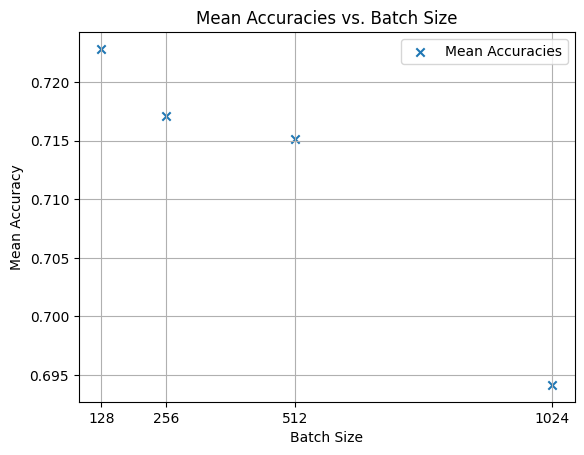

In [5]:
# Calculate the mean accuracies for each batch size
batch_sizes = []
mean_accuracies = []

for batch_size, accuracies in cross_validation_accuracies.items():
    batch_sizes.append(batch_size)
    mean_accuracies.append(sum(accuracies) / len(accuracies))
# Create a scatterplot
plt.scatter(batch_sizes, mean_accuracies, label='Mean Accuracies', marker='x')
plt.xlabel('Batch Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracies vs. Batch Size')
plt.xticks(batch_sizes)

plt.legend()
plt.grid(True)

# Show the plot
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [6]:
mean_times = [sum(values) / len(values) for key, values in cross_validation_times.items()]
df = pd.DataFrame({'Batch Size': [128, 256, 512, 1024],
                   'Last Epoch Time':mean_times
                  })

print(df)
# print(mean_accuracies)
# print(mean_times)
# print((mean_accuracies[0]-mean_accuracies[3])*100/mean_accuracies[0])
# print((mean_accuracies[1]-mean_accuracies[2])*100/mean_accuracies[2])
# print((mean_accuracies[3]-mean_accuracies[1])*100/mean_accuracies[3])

# print((mean_times[3]-mean_times[0])*100/mean_times[3])
# print((mean_times[1]-mean_times[0])*100/mean_times[1])
# print((mean_times[2]-mean_times[1])*100/mean_times[2])

   Batch Size  Last Epoch Time
0         128         0.264181
1         256         0.243902
2         512         0.143303
3        1024         0.134835
[0.722835272237939, 0.7171479982132674, 0.7151334992709792, 0.6941590557286414]
[0.26418118476867675, 0.24390249252319335, 0.1433028221130371, 0.1348346710205078]
3.9671855553637183
0.28169550780962305
-3.3117687214344538
-95.929713603481
-8.314261996955624
-70.20076012934577


In [7]:
# YOUR CODE HERE
optimal_batch_size = 256
reason ="""-The training time for each batch size [128, 256, 512, 1024] has been calculated by averaging the last epoch training times over the 5 folds. 
-The fastest training time is achieved by batch size 1024 but the accuracy is the lowest ie., 0.6942. 
-The accuracy of batch size 128 is the highest and it is 3.97% higher than the accuracy of batch size 1024.
-The training time difference between the batch sizes of 1024 and 128 is significant (137.37% difference).
-Analysing the numbers, the ideal batch size is 256. It has an ideal compromise between training time and mean accuracy.
-The values of batch size 256 has similar values to batch size 512 but since 256 has a better accuracy and a slightly slower training time.
"""